## Imports

In [10]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [11]:
def solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    ###Assign initial conditions
    # set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    for n in range(nt):
        for i in range(1,ny-1):
            for j in range(1,nx-1):
                u[i,j]=u[i,j]+nu*(dt/dx**2)*(u[i+1,j]-2*u[i,j]+u[i-1,j])+nu*(dt/dy**2)*(u[i,j+1]-2*u[i,j]+u[i,j-1])
        #un[:,:]=u[:,:]  
        u[0,:]=1
        u[nx-1,:]=1
        u[:,0]=1
        u[:,ny-1]=1 
    
    
    #fill the update of u
        
    return 0

## Numba accelerator

In [12]:
@njit(fastmath=True)
def solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    ###Assign initial conditions
    # set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    for n in range(nt):
        for i in range(1,ny-1):
            for j in range(1,nx-1):
                u[i,j]=u[i,j]+nu*(dt/dx**2)*(u[i+1,j]-2*u[i,j]+u[i-1,j])+nu*(dt/dy**2)*(u[i,j+1]-2*u[i,j]+u[i,j-1])
        #un[:,:]=u[:,:]  
        u[0,:]=1
        u[nx-1,:]=1
        u[:,0]=1
        u[:,ny-1]=1 
    
    #fill the update of u
        
    return 0

## Pyccel accelerator

In [13]:
@types('float[:,:]', 'float[:,:]', 'int', 'float','float', 'float','float')
def solve_2d_diff_pyccel(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    ##Assign initial conditions
    #set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    
    
    #fill the update of u and v
    for n in range(nt):
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j]=u[i,j]+nu*(dt/dx**2)*(u[i+1,j]-2*u[i,j]+u[i-1,j])+nu*(dt/dy**2)*(u[i,j+1]-2*u[i,j]+u[i,j-1])
        #un=u
        #u=un
        u[0,:]=1
        u[row-1,:]=1
        u[:,0]=1
        u[:,col-1]=1 
        
    return 0

## Inputs

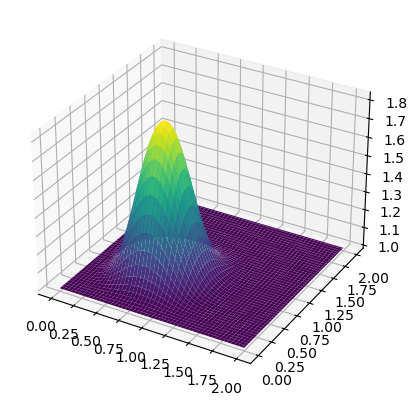

In [14]:
###variable declarations
nt = 60
nx = 100
ny = 100
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
un = np.ones((ny, nx))
    

solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)

## Call Funtions

### Pure function

In [15]:
%timeit solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

3.48 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [16]:
%timeit solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu)

6.12 ms ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [17]:
solve_2d_diff_f90 = epyccel(solve_2d_diff_pyccel)

In [18]:
%timeit solve_2d_diff_f90(u, un, nt, dt, dx, dy, nu)

5.55 ms ± 60.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
